In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from functools import partial
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(1)
#cluster = PBSCluster(cores=28, processes=14, walltime='01:30:00')
#w = cluster.scale(1*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [42]:
client

Client Scheduler: tcp://10.148.0.110:34311 Dashboard: http://10.148.0.110:8787/status,Cluster Workers: 1 Cores: 28 Memory: 120.00 GB


____________
## Read AVISO data

In [43]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
ds = xr.open_zarr(out_dir_zarr+'AVISO_uv_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

 data size: 12.1 GB


In [44]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [45]:
grid = Grid(ds_full, periodic=['X','Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   lat --> left
  * left     lat_left --> center
X Axis (periodic):
  * center   lon --> left
  * left     lon_left --> center

In [46]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)
dlatg[0]=0.25
dlatc[-1]=0.25

In [47]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [48]:
ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 27750.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 27750.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 1680063.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v    

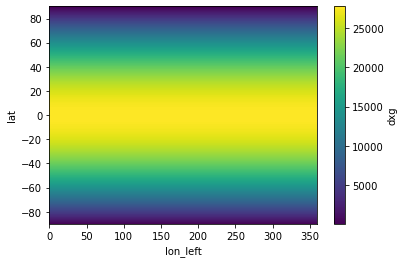

In [49]:
ds_full.dxg.plot(x='lon_left',y='lat')

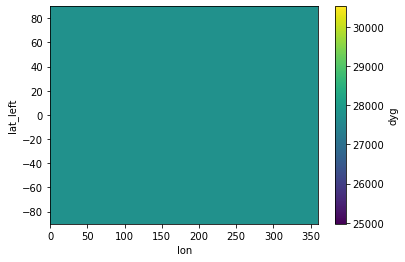

In [50]:
ds_full.dyg.plot(x='lon',y='lat_left')

In [51]:
du_dx = grid.diff(ds_full.u.where(ds.u>-20), 'X') / ds_full.dxg
du_dx_ij = grid.interp(du_dx, 'X')
du_dx_ij = np.real(du_dx_ij).rename('du_dx_ij') 
du_dx_ij

<xarray.DataArray 'du_dx_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [52]:
du_dy = grid.diff(ds_full.u.where(ds.u>-20), 'Y') / ds_full.dyg
du_dy_ij = grid.interp(du_dy, 'Y')
du_dy_ij = np.real(du_dy_ij).rename('du_dy_ij') 
du_dy_ij

<xarray.DataArray 'du_dy_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [53]:
dv_dx = grid.diff(ds_full.v.where(ds.u>-20), 'X') / ds_full.dxg
dv_dx_ij = grid.interp(dv_dx, 'X')
dv_dx_ij = np.real(dv_dx_ij).rename('dv_dx_ij') 
dv_dx_ij

<xarray.DataArray 'dv_dx_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [54]:
dv_dy = grid.diff(ds_full.v.where(ds.u>-20), 'Y') / ds_full.dyg
dv_dy_ij = grid.interp(dv_dy, 'Y')
dv_dy_ij = np.real(dv_dy_ij).rename('dv_dy_ij') 
dv_dy_ij

<xarray.DataArray 'dv_dy_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [55]:
def iters_to_date(iters, delta_t=24*3600.):
    t0 = datetime.datetime(2012,1,1)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [56]:
time_day = iters_to_date(np.arange(731))

In [57]:
ds_cg = xr.merge([ds_full, du_dx_ij, du_dy_ij, dv_dx_ij, dv_dy_ij])
ds_cg

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 27750.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 27750.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 1680063.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v    

In [58]:
ds_cg = ds_cg.assign_coords(time=time_day) 
print(ds_cg)

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 27750.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 27750.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 1680063.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v    

In [59]:
chunks = {'lat': 1, 'lon': 1440, 'time':731}            
ds_cg = ds_cg.chunk(chunks)
#ds_cg = ds_cg.isel(time=slice(248,613))
ds_cg

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
    dyg       (lon, lat_left) float32 dask.array<chunksize=(1440, 720), meta=np.ndarray>
    dxc       (lon, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
    dyc       (lon, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
    area_c    (lon, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(73

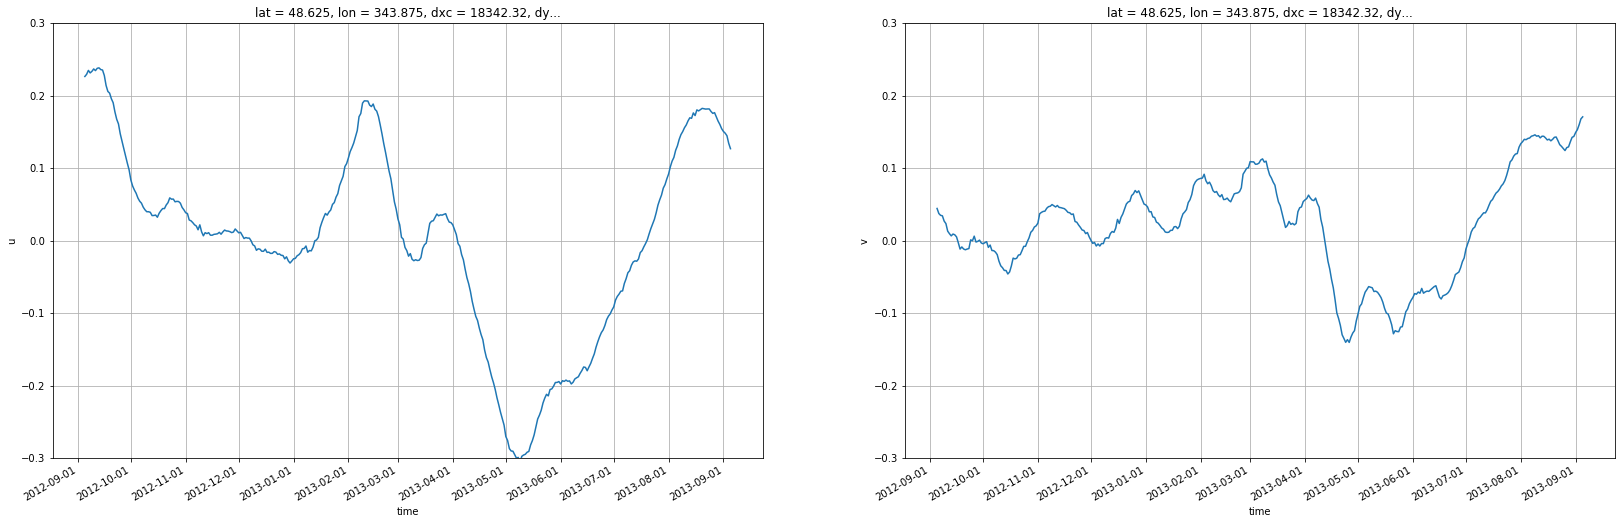

In [60]:
fig, ax = plt.subplots(figsize=(28,8))

ax = plt.subplot(121)
(ds_cg.u.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
#PI_cg_60h_cumsum.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()
ax.set_ylim([-.3, .3])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])

ax = plt.subplot(122)
(ds_cg.v.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
#PI_cg_60h_cumsum.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()
ax.set_ylim([-.3, .3])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


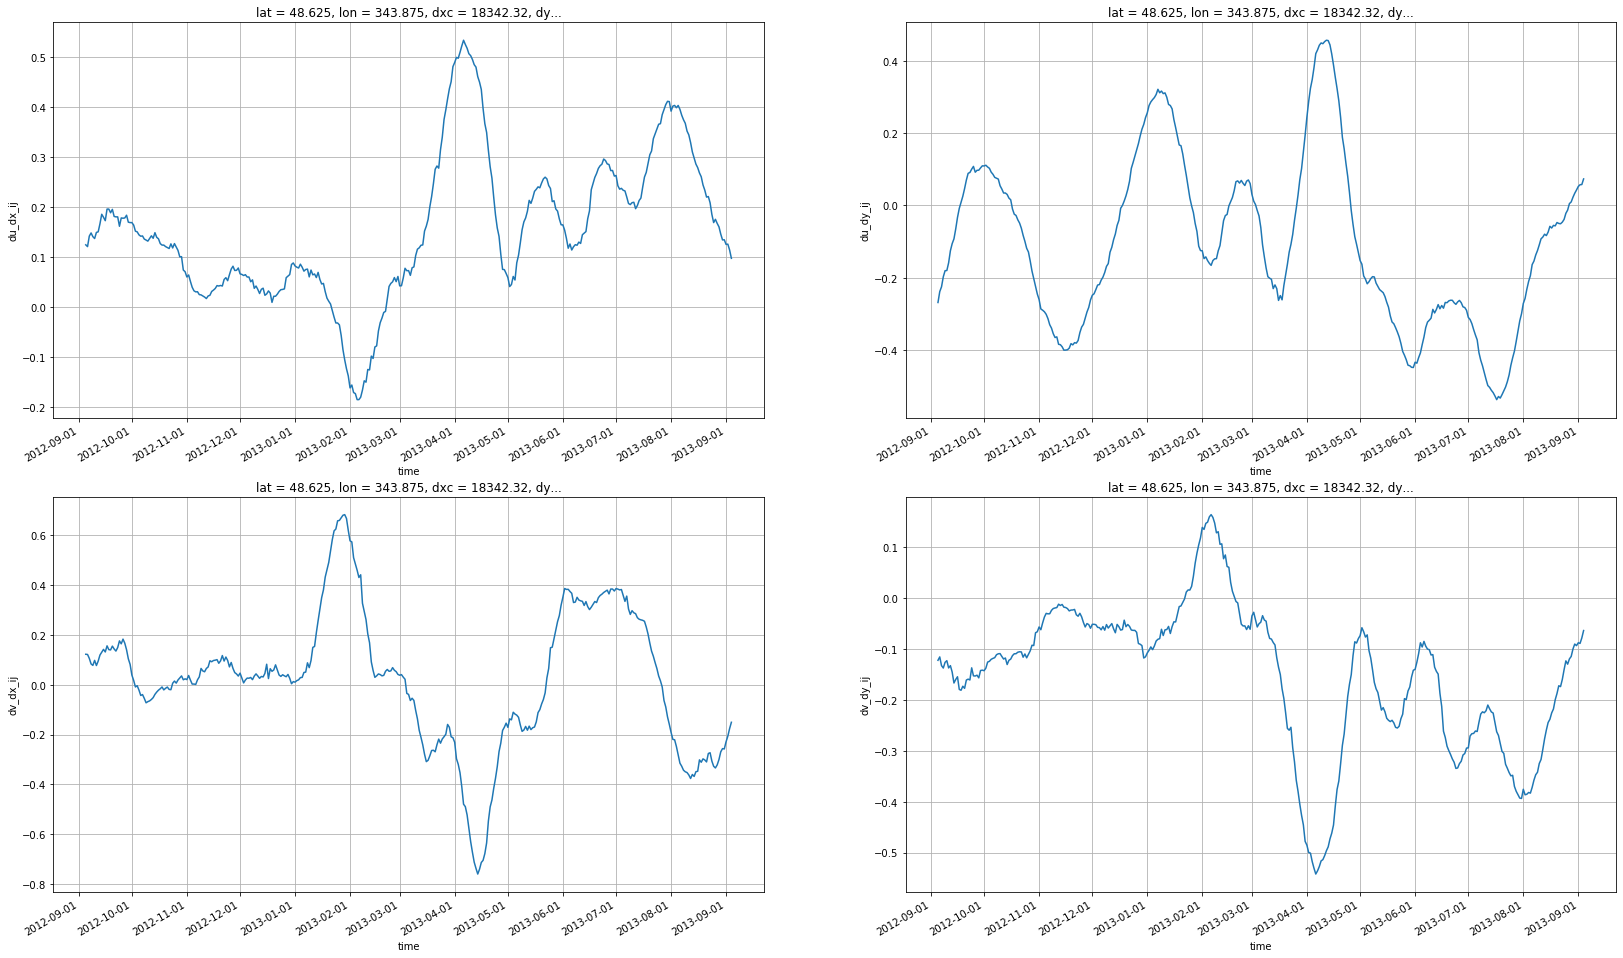

In [20]:
fig, ax = plt.subplots(figsize=(28,16))

ax = plt.subplot(221)
(100000*ds_cg.du_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
#PI_cg_60h_cumsum.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()
#ax.set_ylim([-2e-7, 2e-7])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])

ax = plt.subplot(222)
(100000*ds_cg.du_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
#PI_cg_60h_cumsum.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()
#ax.set_ylim([-2e-7, 2e-7])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])

ax = plt.subplot(223)
(100000*ds_cg.dv_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
#PI_cg_60h_cumsum.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()
#ax.set_ylim([-2e-7, 2e-7])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])

ax = plt.subplot(224)
(100000*ds_cg.dv_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
#PI_cg_60h_cumsum.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()
#ax.set_ylim([-2e-7, 2e-7])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])


__________

# Butterworth filter

In [24]:
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

In [25]:
lowcut = 1/120

fs = 1 # daily data
nyq = 0.5*fs
low = lowcut/nyq
b, a = butter(4, low, 'low')

In [26]:
PI_1 = ( butter_filter(ds_cg.u**2, b, a) - butter_filter(ds_cg.u, b, a)**2 ) * butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = ( butter_filter(ds_cg.v**2, b, a) - butter_filter(ds_cg.v, b, a)**2 ) * butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = ( butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a) * butter_filter(ds_cg.v, b, a) ) * (butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))

PI_cg_60h = -(PI_1+PI_2+PI_3)
PI_cg_60h = PI_cg_60h.persist()

In [28]:
PI_cg_60h_cumsum = 3600*24*PI_cg_60h.sel(time=slice('2012-09-05', '2013-09-5')).cumsum(['time'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


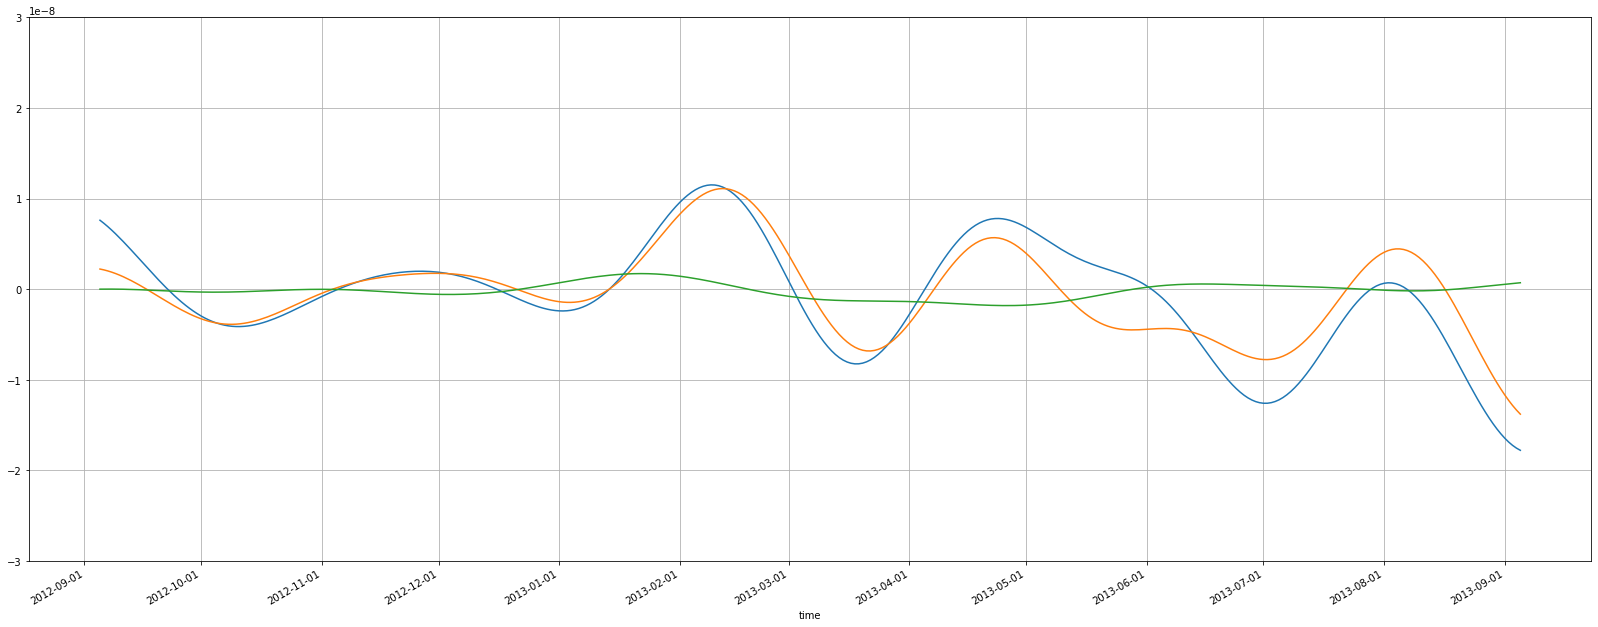

In [38]:
fig, ax = plt.subplots(figsize=(28,10))
ax = plt.subplot(111)
PI_cg_60h.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot()
PI_cg_60h.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5')).plot()

PI_cg_60h.sel(lat=slice(46,50),lon=slice(340,346)).mean(['lat','lon']).sel(time=slice('2012-09-05', '2013-09-5')).plot()
PI_cg_60h.isel(lat=slice(46,50),lon=slice(340,346)).mean(['lat','lon']).sel(time=slice('2012-09-05', '2013-09-5')).plot()


ax.set_ylim([-3e-8, 3e-8])
ax.grid()
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])

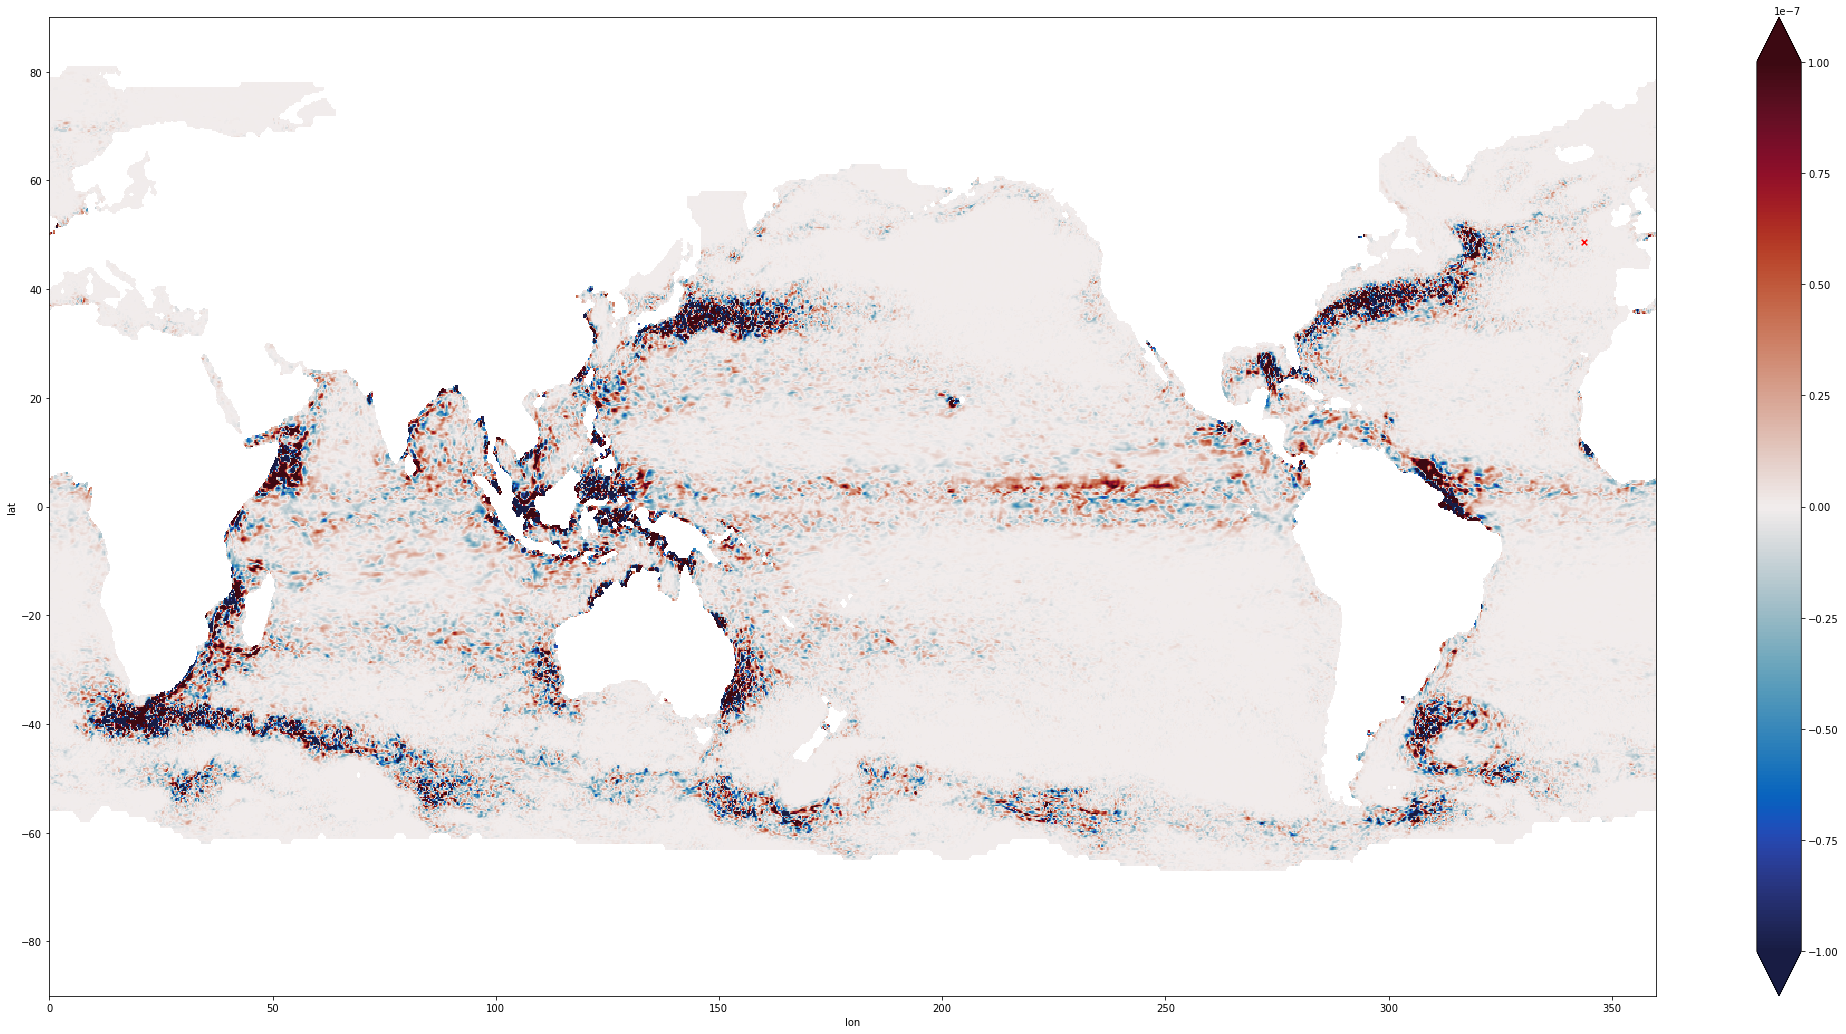

In [33]:
# divergence
fig = plt.figure(figsize=(36,18))
ax = plt.subplot(111)
PI_cg_60h.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

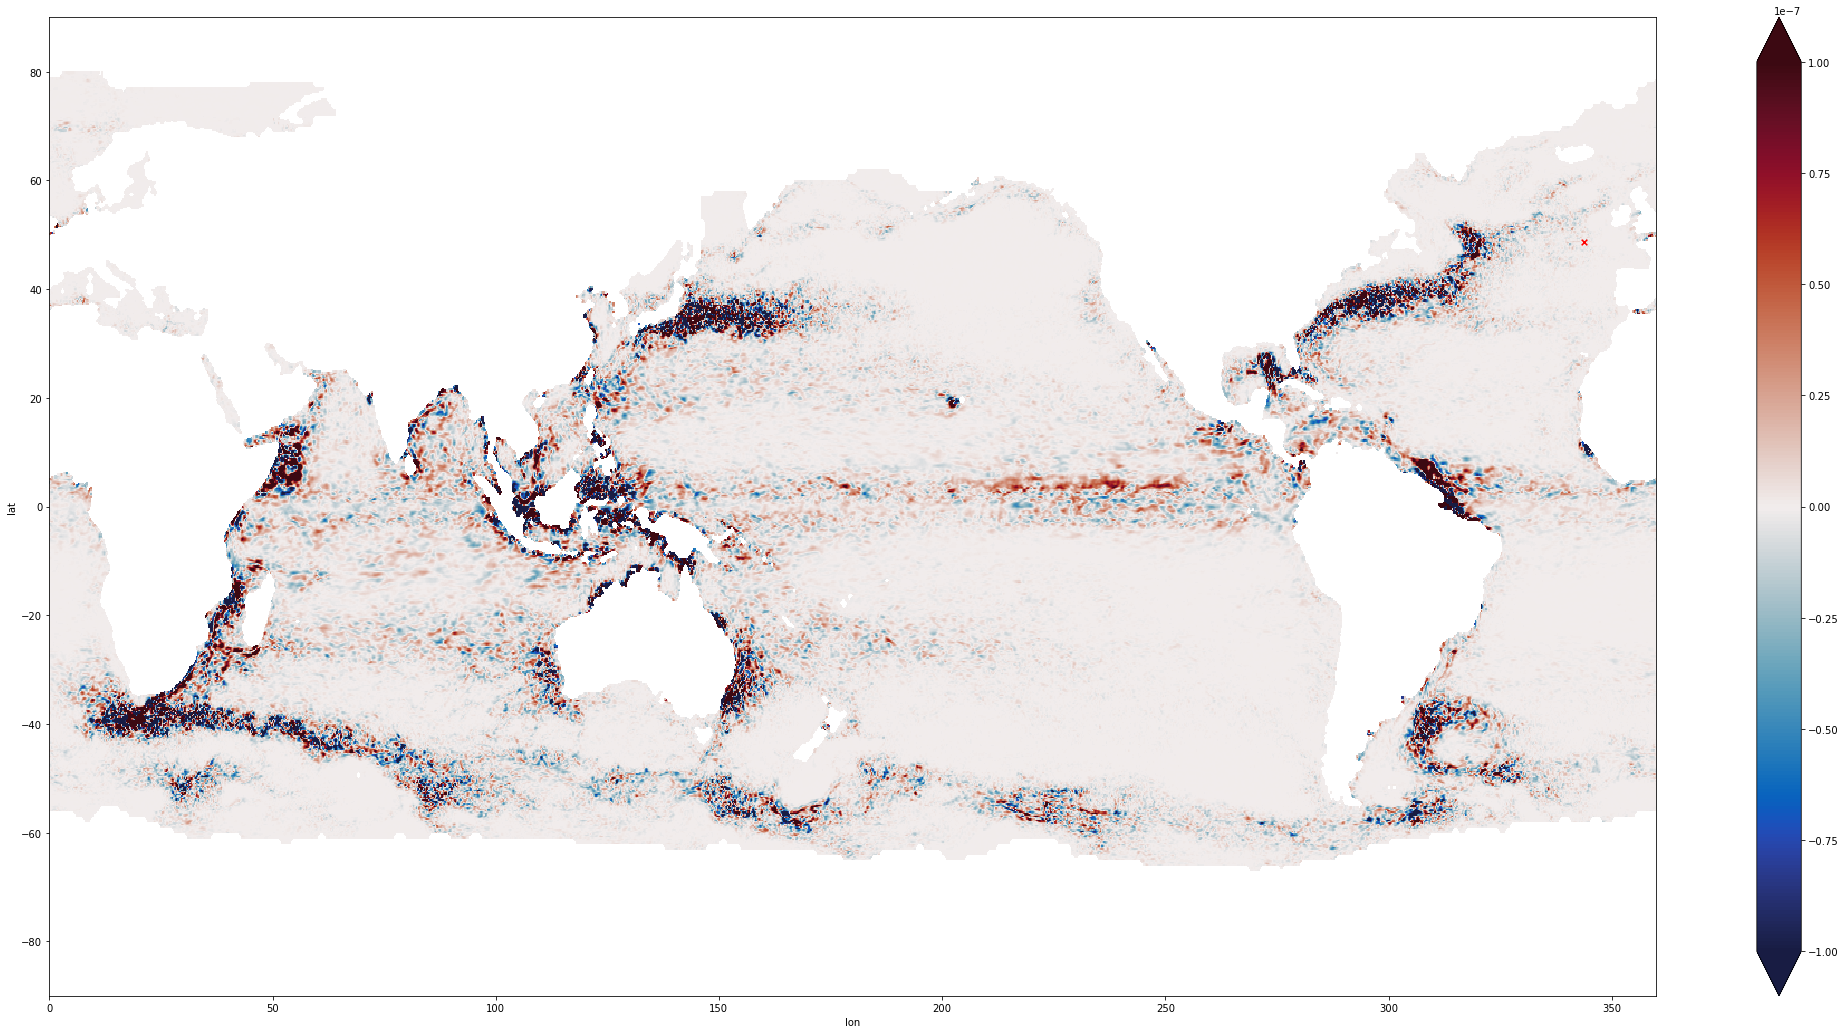

In [39]:
# divergence
fig = plt.figure(figsize=(36,18))
ax = plt.subplot(111)
PI_cg_60h.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

(330.0, 360.0)

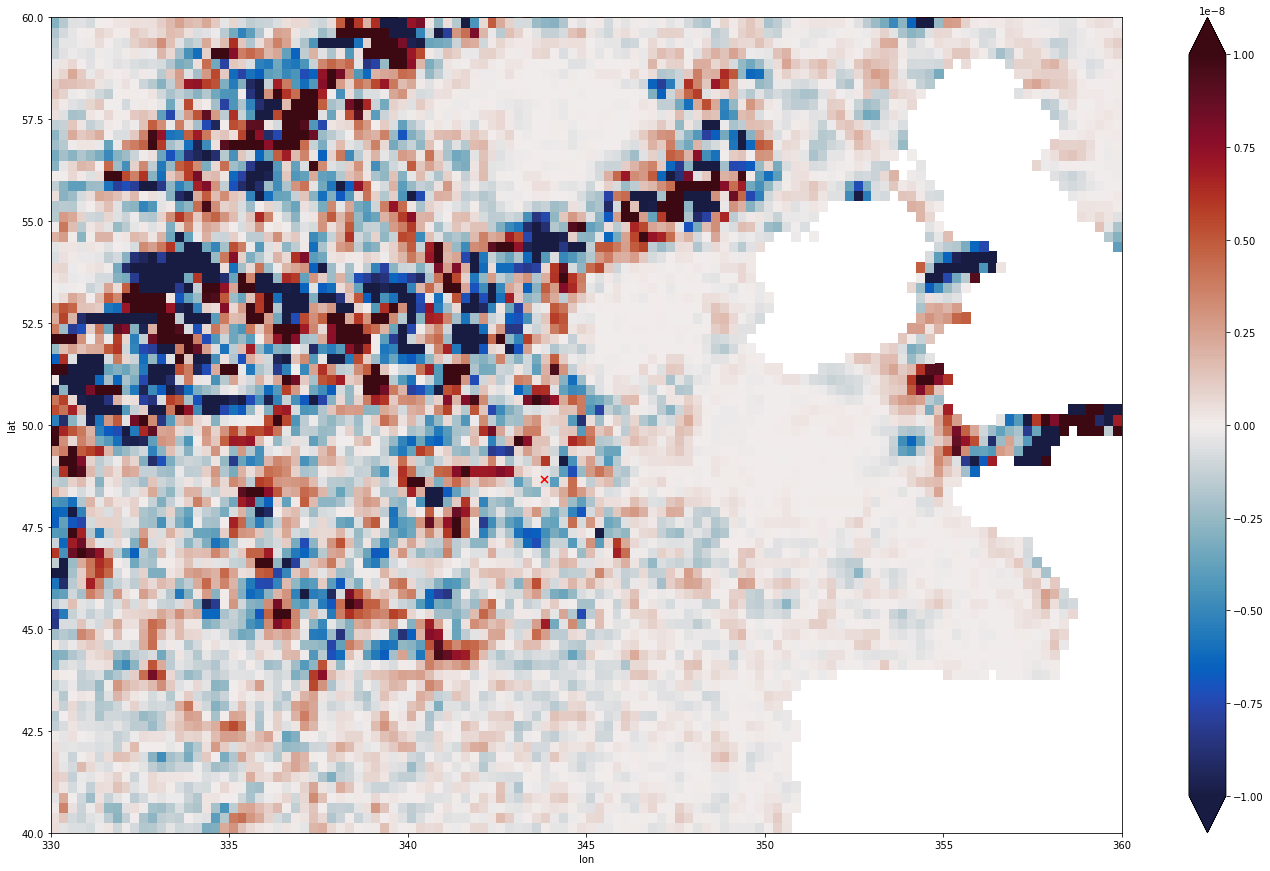

In [40]:
# divergence
fig = plt.figure(figsize=(24,15))
ax = plt.subplot(111)
PI_cg_60h.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-8,vmax=1e-8,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=50,marker='x',color='r')
ax.set_ylim([40., 60.])
ax.set_xlim([330., 360.])

______
# Comparison

In [35]:
ds_cg

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
    dyg       (lon, lat_left) float32 dask.array<chunksize=(1440, 720), meta=np.ndarray>
    dxc       (lon, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
    dyc       (lon, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
    area_c    (lon, lat) float32 dask.array<chunksize=(1440, 1), meta=np.ndarray>
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(73

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


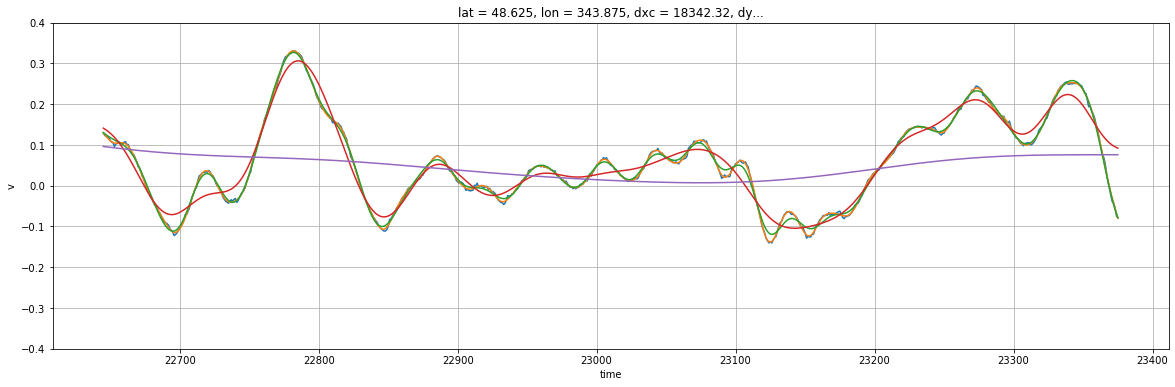

In [41]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)

ds_cg.v.sel(lat=48.6875,lon=343.8125,method='nearest').plot()


b, a = butter(4, low0, 'low')
butter_filter(ds_cg.v, b, a).sel(lat=48.6875,lon=343.8125,method='nearest').plot()

b, a = butter(4, low1, 'low')
butter_filter(ds_cg.v, b, a).sel(lat=48.6875,lon=343.8125,method='nearest').plot()

b, a = butter(4, low2, 'low')
butter_filter(ds_cg.v, b, a).sel(lat=48.6875,lon=343.8125,method='nearest').plot()

b, a = butter(4, low6, 'low')
butter_filter(ds_cg.v, b, a).sel(lat=48.6875,lon=343.8125,method='nearest').plot()



ax.set_ylim([-.4, .4])
ax.grid()

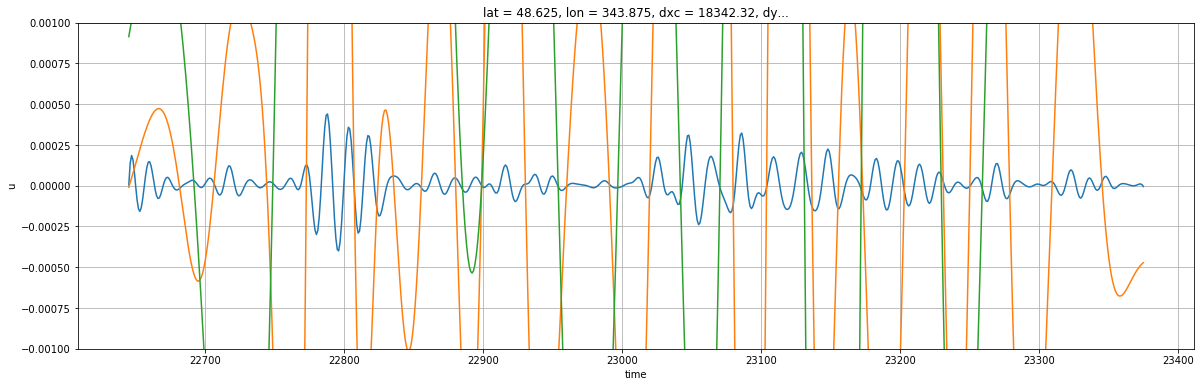

In [48]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)

b, a = butter(4, low0, 'low')
((butter_filter(ds_cg.u*ds_cg.u, b, a)-butter_filter(ds_cg.u, b, a)**2)).sel(lat=48.6875,lon=343.8125,method='nearest').plot()

b, a = butter(4, low2, 'low')
((butter_filter(ds_cg.u*ds_cg.u, b, a)-butter_filter(ds_cg.u, b, a)**2)).sel(lat=48.6875,lon=343.8125,method='nearest').plot()

b, a = butter(4, low4, 'low')
((butter_filter(ds_cg.u*ds_cg.u, b, a)-butter_filter(ds_cg.u, b, a)**2)).sel(lat=48.6875,lon=343.8125,method='nearest').plot()


ax.set_ylim([-1e-3, 1e-3])
ax.grid()

In [18]:
lowcut0 = 1/15
lowcut1 = 1/30
lowcut2 = 1/60
lowcut3 = 1/90
lowcut4 = 1/120
lowcut5 = 1/240
lowcut6 = 1/360

fs = 1 # daily data
nyq = 0.5*fs

low0 = lowcut0/nyq
low1 = lowcut1/nyq
low2 = lowcut2/nyq
low3 = lowcut3/nyq
low4 = lowcut4/nyq
low5 = lowcut5/nyq
low6 = lowcut6/nyq

In [19]:
b, a = butter(4, low0, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_15h = -(PI_1+PI_2+PI_3)

In [20]:
b, a = butter(4, low1, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_30h = -(PI_1+PI_2+PI_3)

In [21]:
b, a = butter(4, low2, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_60h = -(PI_1+PI_2+PI_3)

In [22]:
b, a = butter(4, low3, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_90h = -(PI_1+PI_2+PI_3)

In [23]:
b, a = butter(4, low4, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_120h = -(PI_1+PI_2+PI_3)

In [24]:
b, a = butter(4, low5, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_240h = -(PI_1+PI_2+PI_3)

In [25]:
b, a = butter(4, low6, 'low')
PI_1 = (butter_filter(ds_cg.u**2, b, a)-butter_filter(ds_cg.u, b, a)**2)*butter_filter(ds_cg.du_dx_ij, b, a)
PI_2 = (butter_filter(ds_cg.v**2, b, a)-butter_filter(ds_cg.v, b, a)**2)*butter_filter(ds_cg.dv_dy_ij, b, a)
PI_3 = (butter_filter(ds_cg.u*ds_cg.v, b, a) - butter_filter(ds_cg.u, b, a)*butter_filter(ds_cg.v, b, a) )*(butter_filter(ds_cg.du_dy_ij, b, a)+butter_filter(ds_cg.dv_dx_ij, b, a))
PI_cg_360h = -(PI_1+PI_2+PI_3)

In [27]:
PI_cg_15h = np.real(PI_cg_15h).rename('PI_cg_15h') 
PI_cg_30h = np.real(PI_cg_30h).rename('PI_cg_30h') 
PI_cg_60h = np.real(PI_cg_60h).rename('PI_cg_60h') 
PI_cg_90h = np.real(PI_cg_90h).rename('PI_cg_90h') 
PI_cg_120h = np.real(PI_cg_120h).rename('PI_cg_120h') 
PI_cg_240h = np.real(PI_cg_240h).rename('PI_cg_240h') 
PI_cg_360h = np.real(PI_cg_360h).rename('PI_cg_360h') 

In [28]:
ds_Pi = xr.merge([PI_cg_15h, PI_cg_30h, PI_cg_60h, PI_cg_90h, PI_cg_120h, PI_cg_240h, PI_cg_360h])
ds_Pi

<xarray.Dataset>
Dimensions:     (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat         (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon         (lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * time        (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
    dxc         (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc         (lon, lat) float32 27750.0 27750.0 ... 27750.0 -19952250.0
    area_c      (lon, lat) float32 1680063.0 5040041.0 ... -1207965300.0
Data variables:
    PI_cg_15h   (time, lat, lon) float64 dask.array<chunksize=(731, 1, 1440), meta=np.ndarray>
    PI_cg_30h   (time, lat, lon) float64 dask.array<chunksize=(731, 1, 1440), meta=np.ndarray>
    PI_cg_60h   (time, lat, lon) float64 dask.array<chunksize=(731, 1, 1440), meta=np.ndarray>
    PI_cg_90h   (time, lat, lon) float64 dask.array<chunksize=(731, 1, 1440), meta=np.ndarray>
    PI_cg_120h  (time, lat, lon) float64 dask.array<chunksize=(731, 1,

In [ ]:
fig, ax = plt.subplots(figsize=(28,10))
ax = plt.subplot(111)
PI_cg_15h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
PI_cg_30h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
PI_cg_60h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
PI_cg_90h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
PI_cg_120h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
PI_cg_240h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
PI_cg_360h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()

ax.set_ylim([-1e-7, 1e-7])
ax.grid()

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

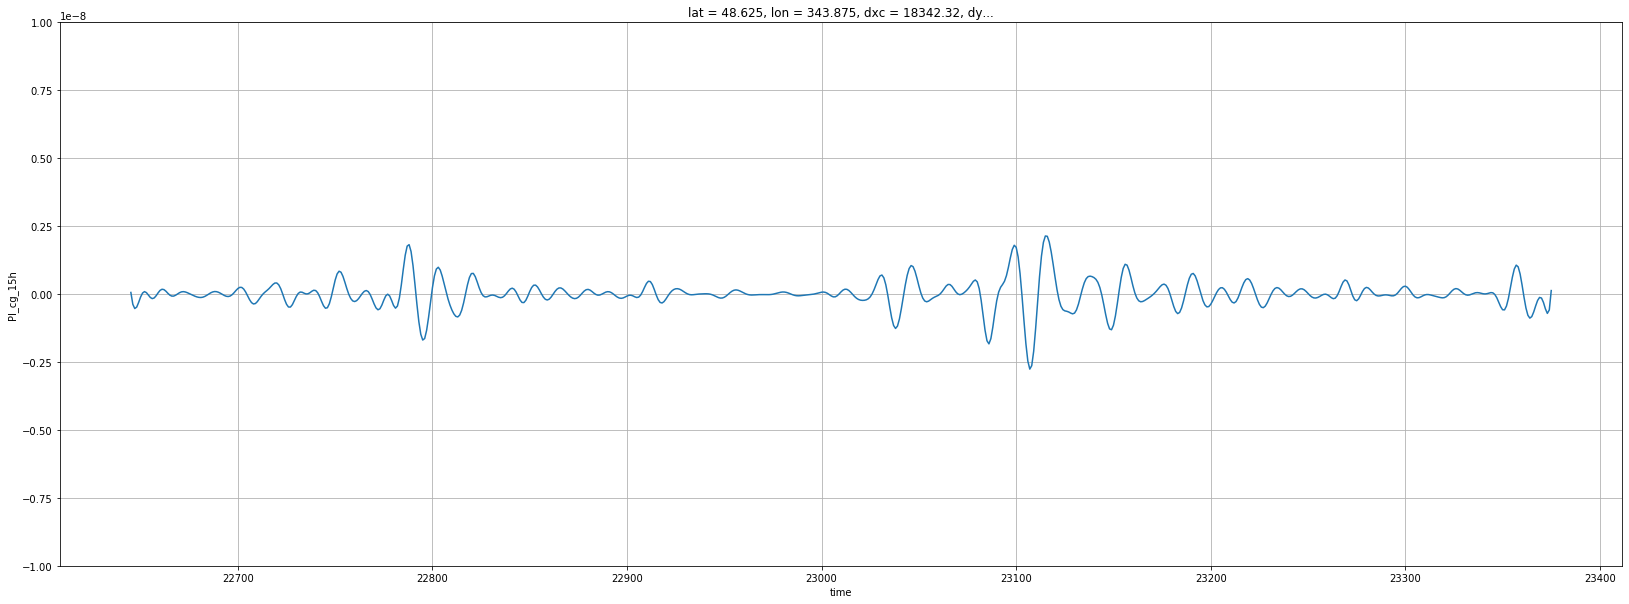

In [32]:
fig, ax = plt.subplots(figsize=(28,10))
ax = plt.subplot(111)
PI_cg_15h.sel(lat=48.6875,lon=343.8125,method='nearest').plot()

ax.set_ylim([-1e-8, 1e-8])
ax.grid()

In [30]:
PI_cg_15h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

array(-3.4570464e-12)

In [28]:
PI_cg_30h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

array(1.29153401e-10)

In [30]:
PI_cg_60h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

array(2.90757385e-09)

In [31]:
PI_cg_90h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

array(1.14698704e-09)

distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


In [29]:
PI_cg_120h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

array(-1.01525984e-09)

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


In [29]:
PI_cg_240h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

NameError: name 'PI_cg_240h' is not defined

In [34]:
PI_cg_360h.sel(lat=48.6875,lon=343.8125,method='nearest').mean(['time']).values

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

array(8.17354227e-10)

In [116]:
cluster.close()

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File 

In [30]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
ds = xr.open_zarr(out_dir_zarr+'AVISO_uv_total_rechunk.zarr')
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [18]:
a2 = ds.apply(gaussian_filter1d, sigma=2.0, axis=0)

In [19]:
a12 = ds.apply(gaussian_filter1d, sigma=12.0, axis=0)

In [23]:
a2.u.get_axis_num(dim='time')

0

In [17]:
ds.u.get_axis_num(dim='time')

0

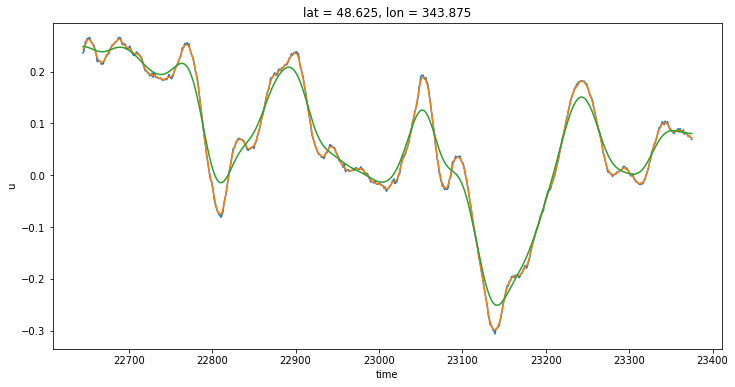

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
ax = plt.subplot(111)

ds.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a2.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a12.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()

In [97]:
def gaussianfilter(x, sigma, axis):
    
    return xr.apply_ufunc(gaussian_filter1d, x, sigma, axis,
                          dask='parallelized',
                          output_dtypes=[x.dtype])

In [107]:
a_24 = gaussianfilter(ds_cg.u, sigma=24, axis=0)
a_72 = gaussianfilter(ds_cg.u, sigma=72, axis=0)
a_120 = gaussianfilter(ds_cg.u, sigma=120, axis=0)

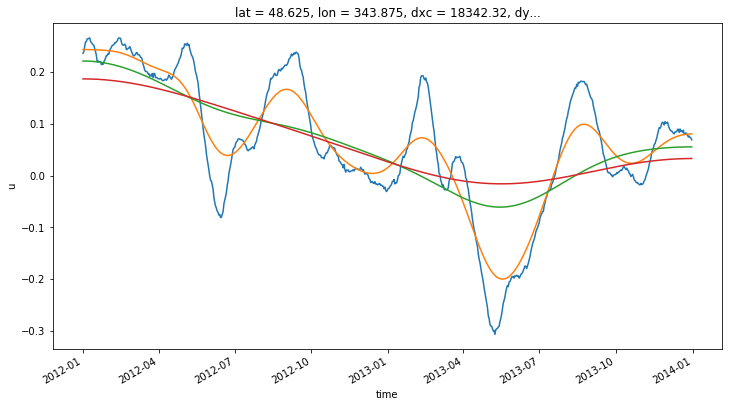

In [108]:
fig, ax = plt.subplots(figsize=(12,6))
ax = plt.subplot(111)
ds_cg.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_24.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_72.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_120.sel(lat=48.6875,lon=343.8125,method='nearest').plot()